In [35]:
import random
import json
import re
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

random.seed(6)
np.random.seed(6)


# Experiment - New Version of Gemma3:4b on chat mode

This is the usual experiment of MCQA on ground tuth but with the new version of Gemma3, optimized for quantization.

**Parameters:**
- model: Gemma3 4b
- system prompt: MCQ_system_promtp_ZS_CoT.txt
- user_prompt: MCQ_user_prompt_ZS_CoT_v2.txt
- temperature: 0.1
- sampling method: (default) top-p (p=0.9)


**Results:**  
Marginal improve of ~1-2% with respect to the old model

## Prompts

In [68]:
with open('../data/prompts/vqa/user_prompt_v2.txt', 'r') as f:
    pr = f.read()

print(pr)


You are an intelligent video comprehension model and are going to receive as input a sequence of images extracted from a video and a question. You need to analyze and describe the scene unfolding in the video (sequence of frames) following these guidelines:
1. Look for recurring objects;
2. Note that the same object may appear differently across frames due to low image quality, varying viewing angles, or partial obstructions. Carefully check objects with similar features (e.g. shape, color), appearing in different frames, as they may still be the same object;
3. Pay attention to how the person interacts with its environment
4. Understand the directional movement of the people and objects in the video
5. Carefully analyze the chronological sequence of the events occurring in the video;
6. Pay attention to the atomic and fine grained movement, pose and actions of the people in the video. Compose these atomic actions happening across the frame to infer the higher level action performed by

In [37]:
with open('../data/prompts/zero-shot-cot/auto_reply_ZS_CoT.txt', 'r') as f:
    pr = f.read()

print(pr)


Therefore the final answer is?

Your response must be provided in valid JSON format as follows:
{"answer": "your complete answer here"}

IMPORTANT: Always include both the letter (A, B, C, D, etc.) AND the full text of the answer in your response.
Do not abbreviate or shorten the answer. For example, if the correct answer is "A. the laptop", your response 
should be {"answer": "A. the laptop"}, not {"answer": "laptop"} or {"answer": "A"}.\



Let's load the ground truth from the `STAR_QA_question_and_stsg_val.json` file where we extracted QA and spatio-temporal scene graphs

In [38]:
ground_truth = []

with open('../data/datasets/STAR/STAR_annotations/STAR_val_small_1000.json') as f:
    data = json.load(f)
    ground_truth = [{
        'id': sample['question_id'],
        'question': sample['question'],
        'choices': sample['choices'],
        'text': sample['answer'],
    } for sample in data]


# we keep num as str so we can directrly access choices dictionaries
gt_df = pd.DataFrame(ground_truth).astype({'id': 'string', 'text': 'string'})
gt_df.set_index('id', inplace=True)
gt_df


,question,choices,text
id,,,
Feasibility_T5_102,Which object is the person able to throw after...,"[{'choice_id': 0, 'choice': 'The bag.', 'choic...",The clothes.
Feasibility_T2_860,What else is the person able to do with the wi...,"[{'choice_id': 0, 'choice': 'Lie on the window...",Close the window.
Feasibility_T2_556,What else is the person able to do with the cl...,"[{'choice_id': 0, 'choice': 'Tidy up the close...",Open the closet/cabinet.
Prediction_T1_2539,What will the person do next?,"[{'choice_id': 0, 'choice': 'Sit on the floor....",Sit on the floor.
Prediction_T4_1253,Which object would the person throw next after...,"[{'choice_id': 0, 'choice': 'The pillow.', 'ch...",The shoe.
...,...,...,...
Interaction_T1_8913,Which object was taken by the person?,"[{'choice_id': 0, 'choice': 'The paper/noteboo...",The paper/notebook.
Interaction_T1_8967,Which object was taken by the person?,"[{'choice_id': 0, 'choice': 'The towel.', 'cho...",The dish.
Interaction_T2_1847,What did the person do with the paper/notebook?,"[{'choice_id': 0, 'choice': 'Put down.', 'choi...",Took.


## Loading predicted answers evaluation

In [39]:
predictions = []
with open('../outputs/vqa_gemma3:12b-it-qat_20250621_13:28:00.jsonl', mode='r', encoding='utf-8', errors='strict') as f:
    predictions = [json.loads(line) for line in f.readlines()]

# transforming the id key from `qid` to `id` for consistency and `response` to `answer`
predictions_df = pd.DataFrame(predictions, dtype='string').rename(columns={'qid':'id', 'response':'answer'})
predictions_df.set_index('id', inplace=True)
predictions_df


,chat_history
id,
Feasibility_T5_102,"[{'role': 'user', 'content': 'You are an intel..."
Feasibility_T2_860,"[{'role': 'user', 'content': 'You are an intel..."
Feasibility_T2_556,"[{'role': 'user', 'content': 'You are an intel..."
Prediction_T1_2539,"[{'role': 'user', 'content': 'You are an intel..."
Prediction_T4_1253,"[{'role': 'user', 'content': 'You are an intel..."
...,...
Interaction_T1_8913,"[{'role': 'user', 'content': 'You are an intel..."
Interaction_T1_8967,"[{'role': 'user', 'content': 'You are an intel..."
Interaction_T2_1847,"[{'role': 'user', 'content': 'You are an intel..."


In [40]:
predictions_df['chat_history'] = \
    predictions_df['chat_history'] \
    .apply(lambda x: eval(x))

predictions_df


,chat_history
id,
Feasibility_T5_102,"[{'role': 'user', 'content': 'You are an intel..."
Feasibility_T2_860,"[{'role': 'user', 'content': 'You are an intel..."
Feasibility_T2_556,"[{'role': 'user', 'content': 'You are an intel..."
Prediction_T1_2539,"[{'role': 'user', 'content': 'You are an intel..."
Prediction_T4_1253,"[{'role': 'user', 'content': 'You are an intel..."
...,...
Interaction_T1_8913,"[{'role': 'user', 'content': 'You are an intel..."
Interaction_T1_8967,"[{'role': 'user', 'content': 'You are an intel..."
Interaction_T2_1847,"[{'role': 'user', 'content': 'You are an intel..."


In [41]:
predictions_df['answer'] = predictions_df['chat_history'].apply(lambda x: x[-1]['content'])


In [42]:
predictions_df['answer'].iloc[0:5] 


id
Feasibility_T5_102            ```json\n{"answer": "A. The bag."}\n```\n
Feasibility_T2_860     ```json\n{"answer": "E. None of the above"}\n```
Feasibility_T2_556    ```json\n{"answer": "A. Tidy up the closet/cab...
Prediction_T1_2539                     {"answer": "B. Open the bag."}\n
Prediction_T4_1253                 {"answer": "E. None of the above"}\n
Name: answer, dtype: object

In [43]:
predictions_df['answer'].iloc[0:5] 


id
Feasibility_T5_102            ```json\n{"answer": "A. The bag."}\n```\n
Feasibility_T2_860     ```json\n{"answer": "E. None of the above"}\n```
Feasibility_T2_556    ```json\n{"answer": "A. Tidy up the closet/cab...
Prediction_T1_2539                     {"answer": "B. Open the bag."}\n
Prediction_T4_1253                 {"answer": "E. None of the above"}\n
Name: answer, dtype: object

## Text preprocessing

For Gemma we need to be more careful becuase the format is different, it encapsulated the json output in the with the tokens: 
```
```json\n
<actual_answer>
\n```
```

In [44]:

# Create mask for answers that follow JSON syntax
json_mask = predictions_df['answer'].str.match(r'^(```json\s*)?({[^}]+})(\s*```)?')
matches_json_template = json_mask.sum()

print(f"Total answers: {len(predictions_df)}")
print(f"Answers following JSON template: {matches_json_template}")
print(f"Percentage following JSON template: {(matches_json_template/len(predictions_df))*100:.2f}%")


Total answers: 1048
Answers following JSON template: 1048
Percentage following JSON template: 100.00%


In [45]:
predictions_df.loc[~json_mask, 'answer']


Series([], Name: answer, dtype: object)

In [46]:
predictions_df.loc[json_mask, 'answer'] = \
    predictions_df.loc[json_mask, 'answer'] \
    .apply(lambda x: re.search(r'^(?:```json\s*)?({[^}]+})(?:\s*```)?', x).group(1))

predictions_df.loc[~json_mask, 'answer'] = ""
predictions_df['answer']


id
Feasibility_T5_102                        {"answer": "A. The bag."}
Feasibility_T2_860               {"answer": "E. None of the above"}
Feasibility_T2_556     {"answer": "A. Tidy up the closet/cabinet."}
Prediction_T1_2539                   {"answer": "B. Open the bag."}
Prediction_T4_1253               {"answer": "E. None of the above"}
                                           ...                     
Interaction_T1_8913            {"answer": "A. The paper/notebook."}
Interaction_T1_8967                      {"answer": "B. The food."}
Interaction_T2_1847              {"answer": "E. None of the above"}
Interaction_T2_3423                       {"answer": "C. Lied on."}
Interaction_T4_4181              {"answer": "C. Put down the bag."}
Name: answer, Length: 1048, dtype: object

### The need to replace single quotes

In [47]:
print('\u2018'), print('\u2019'), print('\u201a'), print('\u201b'), print('\u201c'), print('\u201d')


‘
’
‚
‛
“
”


(None, None, None, None, None, None)

### Applying changes

In [48]:
# Replace new line (lead to EOF Errors) with whitespace
predictions_df['answer'] = \
    predictions_df['answer'].str.replace('\n+', ' ', regex=True)

# Replace lef and right quotation mark with simple quotation mark
predictions_df['answer'] = \
    predictions_df['answer'].str.replace('[\u2018-\u201b]', '\'', regex=True)
predictions_df['answer'] = \
    predictions_df['answer'].str.replace('[\u201c\u201d]', '"', regex=True)
# ------------------ Removing inner double quotes --------------------
# It may happen that the text may contain inner double quotes before the
# attribute end. This will cause the parser to termiate early and spout
# errors for the remaining text. With this snippet we replace those inner
# double quotes with single quotes.
#  
# we first match the text of the reason paramter inside the double quotes
# then we escape/replace all the double quotes inside the text
inside_doublequotes = r"(?<=\"answer\": \")(.*)(?=\"(?:,|}))"

predictions_df['answer'] = \
    predictions_df.apply(
        func=lambda row: re.sub(
            inside_doublequotes, 
            lambda matchobj: matchobj.group(0).replace('\"', ''), 
            row['answer']),
        axis=1
        )


In [49]:
predictions_df.loc[json_mask, 'answer'] = predictions_df.loc[json_mask, 'answer'].apply(lambda x: eval(x)['answer'].strip())
predictions_df


,chat_history,answer
id,,
Feasibility_T5_102,"[{'role': 'user', 'content': 'You are an intel...",A. The bag.
Feasibility_T2_860,"[{'role': 'user', 'content': 'You are an intel...",E. None of the above
Feasibility_T2_556,"[{'role': 'user', 'content': 'You are an intel...",A. Tidy up the closet/cabinet.
Prediction_T1_2539,"[{'role': 'user', 'content': 'You are an intel...",B. Open the bag.
Prediction_T4_1253,"[{'role': 'user', 'content': 'You are an intel...",E. None of the above
...,...,...
Interaction_T1_8913,"[{'role': 'user', 'content': 'You are an intel...",A. The paper/notebook.
Interaction_T1_8967,"[{'role': 'user', 'content': 'You are an intel...",B. The food.
Interaction_T2_1847,"[{'role': 'user', 'content': 'You are an intel...",E. None of the above


In [50]:
ans_regex_pattern = r'^(?:[A-Z]\.)\s+((?:\w+(?:\s|\/)?){,10}\.?)'
contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, regex=True)

print(f"Answer following the template: {contains_answer.value_counts()[True]}\n"
      f"{contains_answer.value_counts()[True]/predictions_df.shape[0]:.2%} of the total")

print(f"\nOnly {contains_answer.shape[0] - contains_answer.value_counts()[True]} samples do not contain the answer in the response with the specified format")


Answer following the template: 1048
100.00% of the total

Only 0 samples do not contain the answer in the response with the specified format


/tmp/ipykernel_358385/2072079659.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, regex=True)


In [51]:
predictions_df.loc[~contains_answer, 'answer']


Series([], Name: answer, dtype: object)

In [52]:
print("\n".join(i[-1]['content'] for i in predictions_df.loc[~contains_answer]['chat_history']))


## Extract answers

In [53]:
ans_df = \
    predictions_df[contains_answer]['answer'] \
    .apply(lambda x: re.findall(ans_regex_pattern, x)[-1]) \
    .apply(lambda x: x + '.' if not x.endswith('.') else x) \
    .to_frame(name='text')

ans_df.rename(columns={0: 'text'}, inplace=True)

ans_df['text'] = ans_df['text'].str.strip()
ans_df


,text
id,
Feasibility_T5_102,The bag.
Feasibility_T2_860,None of the above.
Feasibility_T2_556,Tidy up the closet/cabinet.
Prediction_T1_2539,Open the bag.
Prediction_T4_1253,None of the above.
...,...
Interaction_T1_8913,The paper/notebook.
Interaction_T1_8967,The food.
Interaction_T2_1847,None of the above.


In [54]:
ans_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1048 entries, Feasibility_T5_102 to Interaction_T4_4181
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1048 non-null   object
dtypes: object(1)
memory usage: 48.7+ KB


In [55]:
freq = ans_df['text'].value_counts().reset_index()
freq.columns = ['word', 'freq']

print(f"We have {freq.size} unique answers")


We have 280 unique answers


In [56]:
ans_df['text'].value_counts()


text
None of the above.         300
Put down.                   37
The bag.                    34
The phone/camera.           25
The blanket.                23
                          ... 
Take the laptop.             1
Take the towel.              1
Close the refrigerator.      1
Cradling the baby.           1
Tidy up the blanket.         1
Name: count, Length: 140, dtype: int64

<Axes: xlabel='freq', ylabel='word'>

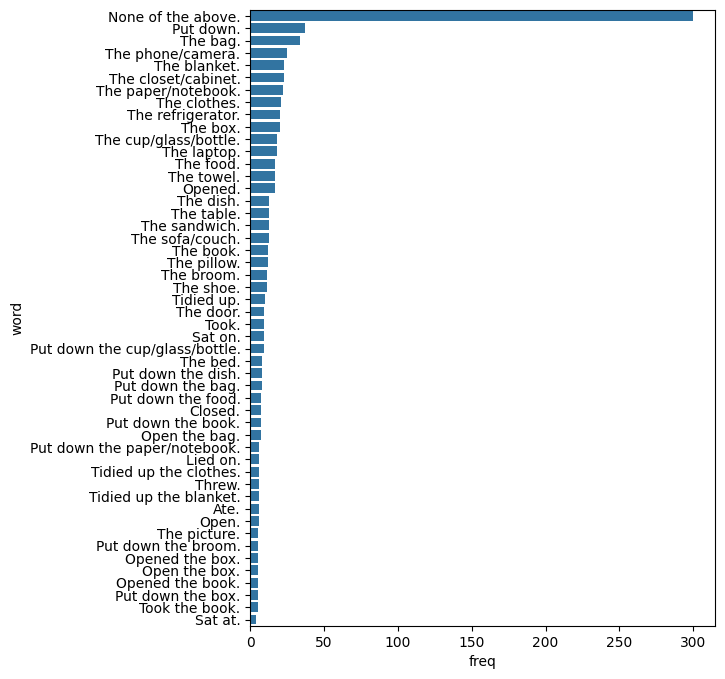

In [57]:
plt.figure(figsize=(6, 8))
sns.barplot(data=freq.sort_values('freq', ascending=False)[:50], x='freq', y='word')


Let's do some visualization also for the ground truth data

In [58]:
print(f"We have {gt_df['text'].nunique()} unique answers")


We have 164 unique answers


<Axes: xlabel='freq', ylabel='word'>

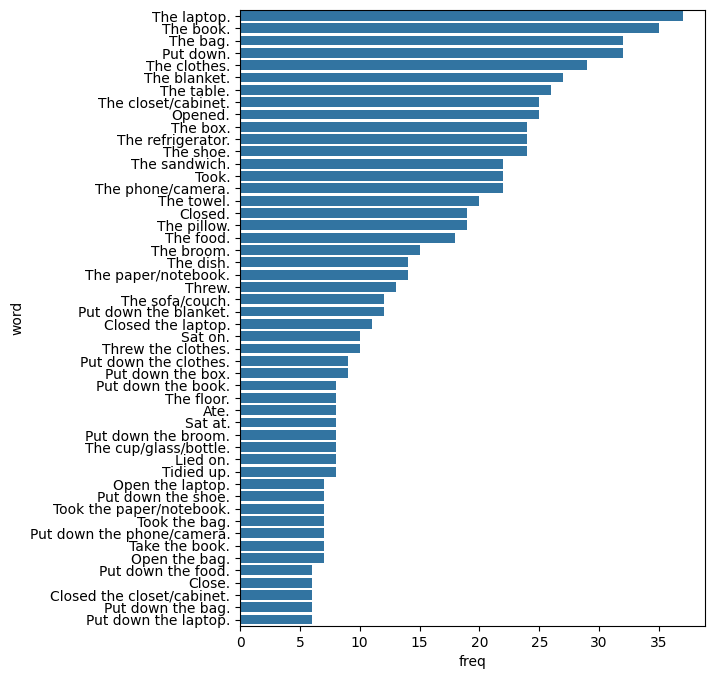

In [59]:
freq = gt_df['text'].value_counts().reset_index()
freq.columns = ['word', 'freq']

plt.figure(figsize=(6, 8))
sns.barplot(data=freq.sort_values('freq', ascending=False)[:50], x='freq', y='word')


In [60]:
# Inner join - keeps only indices present in both series

ans_df.rename(columns={'text': 'pred_text'}, inplace=True)
eval_df = gt_df.join(
    ans_df, 
    how='inner' # we account also for samples without answers
)

eval_df.shape


(1048, 4)

In [61]:
eval_df['text'] = eval_df['text'].str.lower()
eval_df['text'] = eval_df['text'].str.replace('.', '')

eval_df['pred_text'] = eval_df['pred_text'].str.lower()
eval_df['pred_text'] = eval_df['pred_text'].str.replace('.', '')


In [62]:
def accuracy(eval_df, on_what='text'):
    hits_text = (eval_df[f'pred_{on_what}'].str.lower() == eval_df[on_what].str.lower()).sum()
    

    return hits_text/eval_df.shape[0]


check if the equality with NA result in a false or is skipped

In [63]:
real_acc = accuracy(eval_df) * eval_df.shape[0] / gt_df.shape[0]

print(f"Real Accuracy: {real_acc:.2%}")


Real Accuracy: 38.07%


In [64]:
def print_acc(eval_df, acc_fn):
    print(f"{'Question type':<15}{'Total':^15}{'Accuracy':^10}\n")

    total = eval_df.index.str.startswith('Interaction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Interaction')])
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Sequence').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Sequence')])
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Prediction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Prediction')])
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Feasibility').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Feasibility')])
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")


In [65]:
print_acc(eval_df, lambda x: accuracy(x, on_what='text'))


Question type       Total      Accuracy 

Interaction          298        44.97%  
Sequence             291        35.40%  
Prediction           239        38.49%  
Feasibility          220        31.82%  


In [66]:
# % of answers conforming to template per category

def print_ans_perc(eval_df, gt_df):
    print(f"{'Question type':<15}{'Total':^15}{'Answered':^10}\n")

    total = gt_df.index.str.startswith('Interaction').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Interaction')].index))/total
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Sequence').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Sequence')].index))/total
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Prediction').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Prediction')].index))/total
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Feasibility').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Feasibility')].index))/total
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.shape[0]
    acc = eval_df.shape[0]/total
    print(f"{'Overall':<15}{total:^15}{acc:^10.2%}")

print_ans_perc(eval_df, gt_df)


Question type       Total      Answered 

Interaction          298       100.00%  
Sequence             291       100.00%  
Prediction           239       100.00%  
Feasibility          220       100.00%  
Overall             1048       100.00%  


In [67]:
eval_df


,question,choices,text,pred_text
id,,,,
Feasibility_T5_102,Which object is the person able to throw after...,"[{'choice_id': 0, 'choice': 'The bag.', 'choic...",the clothes,the bag
Feasibility_T2_860,What else is the person able to do with the wi...,"[{'choice_id': 0, 'choice': 'Lie on the window...",close the window,none of the above
Feasibility_T2_556,What else is the person able to do with the cl...,"[{'choice_id': 0, 'choice': 'Tidy up the close...",open the closet/cabinet,tidy up the closet/cabinet
Prediction_T1_2539,What will the person do next?,"[{'choice_id': 0, 'choice': 'Sit on the floor....",sit on the floor,open the bag
Prediction_T4_1253,Which object would the person throw next after...,"[{'choice_id': 0, 'choice': 'The pillow.', 'ch...",the shoe,none of the above
...,...,...,...,...
Interaction_T1_8913,Which object was taken by the person?,"[{'choice_id': 0, 'choice': 'The paper/noteboo...",the paper/notebook,the paper/notebook
Interaction_T1_8967,Which object was taken by the person?,"[{'choice_id': 0, 'choice': 'The towel.', 'cho...",the dish,the food
Interaction_T2_1847,What did the person do with the paper/notebook?,"[{'choice_id': 0, 'choice': 'Put down.', 'choi...",took,none of the above
